In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In this exercise we will learn how Bayesian optimization and Hyperband works and how we can combine them to optimize the hyperparameters of a convolutional neural network (CNN) on CIFAR-10. The architecture consists of 3 convolutional layers (with RELU activations and batch norm) and one final fully-connected layer. We use Adam to optimize the weights of the network.


Before you start, make sure that you installed the following dependencies:
- numpy (pip install numpy)
- scipy (pip install scipy)
- sklearn (pip install sklearn==0.18.1) Note: The random forest surrogate was trained with sklearn version  0.18.1 . Newer versions should also work but probably generate some warnings and in future might lead to slightly different results.
- emukit (pip install git+https://github.com/amzn/Emukit.git)
- statsmodel (pip install git+git://github.com/statsmodels/statsmodels.git) you might also need cython for that (pip install cython)

To avoid spending too much time training CNNs, we will not optimize the original benchmark but instead optimize a so-called surrogate benchmark. A surrogate benchmark is basically just a regression model (in our case a random forest) that was trained on a large set of randomly sampled hyperparameter configurations of the original benchmark (CNNs in our case).
Now to evaluate a hyperparameter configuration, we do not actually train the CNN but use the prediction of the regression model, which is much faster to evaluate (miliseconds). We can do that not only for the validation error but also for the training time of the CNN. Obviously, our surrogate is only an approximation of the true benchmark, however just for developing new hyperparameter optimization methods it should be sufficient. You can download the surrogates [here](http://www.ml4aad.org/wp-content/uploads/2018/12/surrogates_cnn.tar.gz).

As in the previous exercises, please hand in a 1 to 2 pages report about what you did.

In [4]:
from copy import deepcopy

rf = pickle.load(open("./rf_surrogate_cnn.pkl", "rb"))
cost_rf = pickle.load(open("./rf_cost_surrogate_cnn.pkl", "rb"))

def objective_function(x, epoch=40):
    """
    Function wrapper to approximate the validation error after N epochs of the hyperparameter configurations
    x by the prediction of a surrogate regression model, which was trained on the validation error of 
    randomly sampled hyperparameter configurations.
    """
    
    # normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = rf.predict(x_norm[None, :])[0]

    return y

def runtime(x, epoch=40):
    """
    Function wrapper to approximate the training time of the hyperparameter configurations x.
    """
    
    # normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = cost_rf.predict(x_norm[None, :])[0]

    return y

/home/welto/.local/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/welto/.local/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Bayesian optimization

We will use [emukit](https://github.com/amzn/emukit) for the Bayesian optimization part of this exercise. Have a look on [the emukit tutorial](https://github.com/amzn/emukit/blob/develop/notebooks/Emukit-tutorial-Bayesian-optimization-introduction.ipynb) for Bayesian optimization to get familiar with it.

The first thing we need to do is to define the configuration space for our CNN surrogate benchmark. We will optimize the learning rate, batch size and the number of filters in each of the 3 convolutional layers and for convenience treat all hyperparamters as continuous variables. For the learning rate and the number of filters it is usually good practice to optimize it on a logarithmic scale. Because of that we optimize the exponent in $log\alpha \in [-6, -1]$ and then in the objective function set the learning rate to $\alpha = 10^{log\alpha}$ (this is handled by our surrogate). For the number of filters $n$ we use a base of 2, i e. $log n \in [4, 10]$ and $n = 2^{log n}$.

In [5]:
from emukit.core import ContinuousParameter, ParameterSpace

list_params = []
list_params.append(ContinuousParameter("learning_rate",-6, -1))
list_params.append(ContinuousParameter("batch_size",32, 512))
list_params.append(ContinuousParameter("n_filters_1", 4, 10))
list_params.append(ContinuousParameter("n_filters_2", 4, 10))
list_params.append(ContinuousParameter("n_filters_3", 4, 10))

space = ParameterSpace(list_params)

## Initial Design

As we have learned in the lecture, Bayesian optimization internally uses a model to guide the search. However, in order to train a model we first need data. Thus, we will first use a so called initial design to collect some data points before we start with the actual Bayesian optimization loop. Here we will simply draw and evaluate N random configurations. However, one could do more sophisticated things such as experimental design or multi-task learning to warmstart the optimization procedure.

In [6]:
from emukit.experimental_design.model_free.random_design import RandomDesign

n_init = 2

# TODO: draw n_init configurations randomly
design = RandomDesign(space)
X_init = design.get_samples(n_init)

# TODO: evaluate all configurations and store them
Y_init = []
for x in X_init:
    Y_init.append([objective_function(x)])
print(Y_init)
Y_init = np.array(Y_init)

[[0.2565435926217015], [0.33369472114956417]]


## BO components

Before we implement the main loop, we have to define the ingredients that are needed for Bayesian optimization:
* a Gaussian process as a probabilistic model for the objective function
* Expected improvement as the acquisition function
* an optimizer for the acquistion function

In [7]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.core.optimization import AcquisitionOptimizer

kernel = GPy.kern.Matern52(X_init.shape[1], ARD=True)
gp = GPyModelWrapper(GPy.models.GPRegression(X_init, Y_init, kernel, noise_var=1e-10))
ei = ExpectedImprovement(gp)
optimizer = AcquisitionOptimizer(space)

## BO loop

Now we can implement the main loop which 1. optimizes the acquisition function, 2. evaluates the objective function 3. augments our dataset and updates our model.
Additionally we will also keep track of the current best solution we have found (dubbed incumbent) which BO will ultimately return to the user. Again, there are differnt possible ways to identify the incumbent. Here, we will simply use the best observed configuration, but for instance one could also optimize the posterior mean.

To estimate how much time it would have taken to evaluate the real instead of the surrogate benchmark, we also predict the training time of each hyperparameter configuration and plot the incumbent performance over the cumulative runtime.

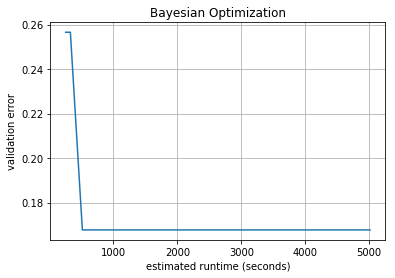

In [8]:
n_iters = 20

incumbent_trajectory = []  # keeps track of the incumbent after each iterations
runtime_trajectory = []   # saves the runtime after each interation
t = 0
current_incumbent = np.argmin(Y_init)
for i in range(n_iters):
    
    # TODO: optimize acquisition function
    x, _ = optimizer.optimize(ei)

    # TODO: evaluate objective function and estimate the training time
    y = objective_function(x[0])
    t += runtime(x[0])

    # TODO: augment data with new observations and update the model
    X_init = np.append(X_init, x,axis=0)
    Y_init = np.append(Y_init, [[y]],axis=0)
    gp.set_data(X_init, Y_init)

    # TODO: bookkeeping of the incumbent and the runtime
    if y < Y_init[current_incumbent]:
        current_incumbent = Y_init.shape[0] - 1
    incumbent_trajectory.append(Y_init[current_incumbent])
    runtime_trajectory.append(t)

plt.plot(runtime_trajectory, incumbent_trajectory)

plt.xlabel("estimated runtime (seconds)")
plt.ylabel("validation error")
plt.grid(True)
plt.title("Bayesian Optimization")
plt.show()

# Hyperband

In the lecture we saw that we often have access to cheap approximations of the objective function, called fidelities. Here, we will use the learning curve, i e. the validation error after each epoch, as fidelity to speed up the optimization process.
This part of the exercise is inspired from Kevin Jamieson's [tutorial](http://people.eecs.berkeley.edu/~kjamieson/hyperband.html). I highly recommend to check it out to gain a better understanding of Hyperband and successive halving.

Instead of maintaining a model as in Bayesian optimization, Hyperband samples configurations randomly. Thus, the first bit we are going to implement is a function that returns a random hyperparameter configuration sampled from a uniform distribution over the same configuration space as above.

In [9]:
def get_random_hyperparameter_configuration():
    # TODO: draw and return a random configuation
    x = design.get_samples(1)[0]
    return x
print(get_random_hyperparameter_configuration())

[ -1.83043983 206.13558142   7.41488576   7.36223057   4.16967394]


Successive halving is a simple bandit strategy to allocate resources to a fixed set of configurations.
Given a set of $N$ configurations, it ranks them based on their performance on the minimum budget and continues only the top $\eta^{-1}$ configurations on a budget which is $\eta$ times larger.

Hyperbands combines random search with successive halving to balance very aggressive evaluation with many configurations on the smallest budget and very conservative runs on the maximum budget.
For that, in each iteration, called bracket, of its outer loop, Hyperband runs successive halving with alternating number of configurations and budgets.

In [50]:
def successive_halving(n, r, s, eta):
    """
    Run one iteration of successive halving
    :param n: initial number of hyperparameter configurations
    :param r: initial number of iterations 
    :param s: defines the tradeoff between r and n
    :param eta: defines downsampling rate
    """
    T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
    for i in range(s+1):
        val_losses = []
        # TODO compute the number of configs n_i and epochs r_i
        n_i = n*eta**(-i)
        r_i = r*eta**i
        print(r_i)
        # TODO run all n_i configuration for r_i epochs
        val_losses = [objective_function(t, epoch=r_i) for t in T ]
        plt.scatter(np.ones(len(val_losses)) * r_i, val_losses)
            
        # TODO: keep only the best n_i/eta configurations
        T = [T[i] for i in np.argsort(val_losses)[0:int( n_i/eta )] ]

1.4814814814814814
4.444444444444445
13.333333333333332
40.0


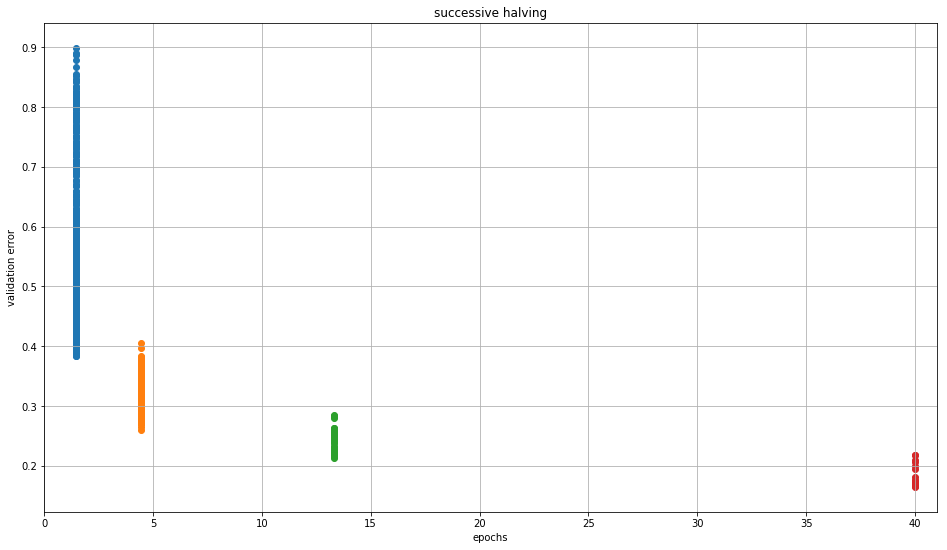

4.444444444444445
13.333333333333334
40.0


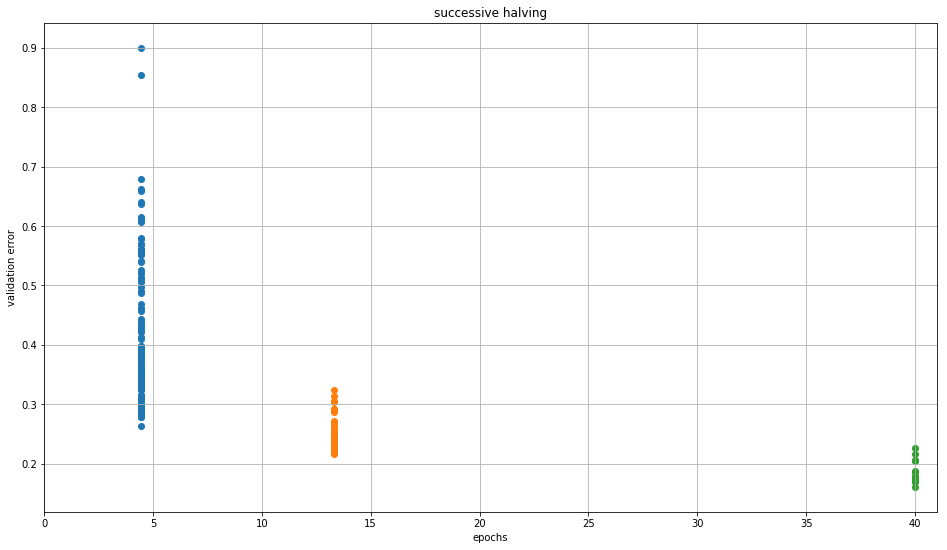

13.333333333333332
40.0


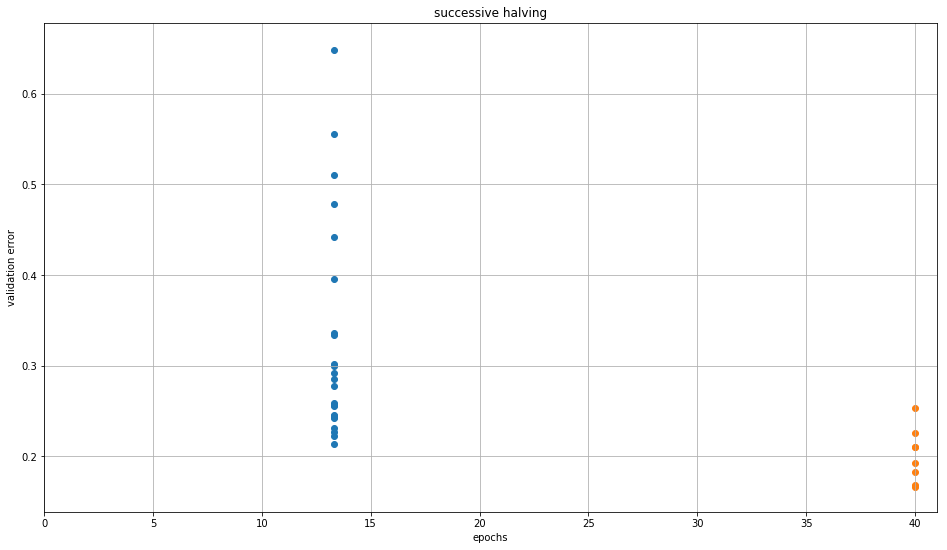

40


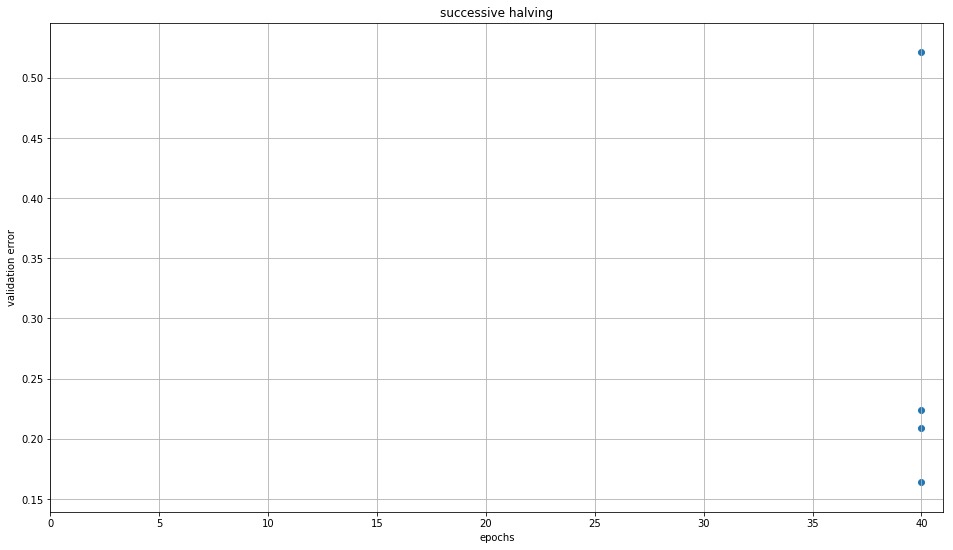

In [51]:
max_iter = 40  # maximum iterations/epochs per configuration
eta = 3 # defines downsampling rate (default=3)
s_max = int(np.log(max_iter)/np.log(eta))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)


for s in reversed(range(s_max+1)):
    # TODO: compute initial number of configurations and initial number to run configurations for
    n = int(np.ceil(int(B*(s+1)/max_iter)*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s)

    # run successive halving
    successive_halving(n, r, s, eta)
    plt.xlabel("epochs")
    plt.ylabel("validation error")
    plt.grid(True)
    plt.title("successive halving")
    plt.xlim(0, 41)
    plt.show()

# Combining Bayesian optimization with Hyperband

One of the weaknesses of Hyperband is that it draws configurations randomly and hence might take exponentially long to approach the global optimum. In the last part of the exercise, we will combine Hyperband with a kernel density estimator that models the distribution of the good and the bad configurations in the input space. By sampling from this model instead of a uniform distribution we can find good configurations much faster.

To implement the kernel density estimator we will use [statsmodel](http://www.statsmodels.org/stable/index.html). In the original implementation of the tree parzen estimator [TPE](http://jaberg.github.io/hyperopt/), they fitted a univariate kernel density estimator for each dimension independently. Even though this allows to quickly train a model it is not able to capture interactions between hyperparameters. Instead, we will use a [multivariate kernel density estimator](http://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html#statsmodels.nonparametric.kernel_density.KDEMultivariate) that fits a distribution over the whole input space.

In [125]:
import statsmodels.api as sm
import scipy.stats as sps

def sample(num_samples=64, random_fraction=1/3, min_bandwidth=1e-3):
    """
    Samples one configuration either randomly or by optimizing expected improvement
    
    :param num_samples: number of samples to optimize expected improvement
    :param random_fraction: fraction of configuration that will be sampled randomly
    :param min_bandwith: minimum allowed bandwith for the kernel density estimator

    
    :return: hyperparameter configuration, boolean flag that indicated whether the configuration was sampled based on the model or not
    """
    # TODO: if no model is available, sample randomly also mix in a fraction (random_fraction) of random configs
    if not kde_models or np.random.rand() < random_fraction:
        return design.get_samples(1)[0], False
    
    # TODO: estimate the largest budget for which we have a model
    budget = max(kde_models.keys())
    
    # define EI acquisition function
    l = kde_models[budget]['good'].pdf
    g = kde_models[budget]['bad' ].pdf
    negative_ei = lambda x: max(1e-32, g(x))/max(l(x),1e-32)  # The acquisition function is always maximized, but since we minimze here we put a minus in fron

    kde_good = kde_models[budget]['good']
    kde_bad = kde_models[budget]['bad']

    # draw num_samples samples
    best_sample = None
    good_configs = configs['good']
    for i in range(num_samples):
        
        # TODO: sample random training data point from the good configurations
        mean = good_configs[np.random.randint(len(good_configs))]

        # TODO: take the training data point as the mean and the KDE bandwidth as std and sample from a multivariate Normal
        x_new = sps.multivariate_normal.rvs(mean=mean, cov=kde_good.bw)
        
        # TODO: compute the EI acquisition function
        y_new = negative_ei(x_new)
        if best_sample is None or best_y < y_new:
            best_y = y_new
            best_sample = x_new
    # TODO: return the best sample with the highest EI value
    return best_sample, True


def update(budget, x, y, min_points_in_model=18, top_n_percent=30, min_bandwidth=1e-3):
    """
    Add new observed x, y to the already collected data on this budget and
    if possible updates the kernel density estimator for the corresponding budget.
    
    :param budget: on which budget the hyperparameter configuration was observed
    :param x: the new observed hyperparameter configuration
    :param y: the corresponding loss
    :param min_points_in_model: the minimum number of datapoint that are need to fit a KDE
    :param top_n_percent: specifies how many percent of the best configurations will be used to train the KDE for the good configurations
    :param min_bandwith: minimum allowed bandwith for the kernel density estimator
    """
    # check if we have already data points for this budget collected
    if budget not in configs.keys():
        configs[budget] = []
        losses[budget] = []

    # store configuration and loss
    configs[budget].append(x)
    losses[budget].append(y)

    # skip model building if not enough points are available
    if len(configs[budget]) <= min_points_in_model-1:
        return

    if budget not in kde_models.keys():
        kde_models[budget] = dict()
    # TODO: split the data points into good configurations, top N percent and the bad configurations
    sorted_conf = [configs[budget][i] for i in np.argsort(-1*np.array(losses[budget]))]
    good = sorted_conf[0:int(np.ceil(len(sorted_conf)*top_n_percent/100))]
    bad = sorted_conf[int(np.ceil(len(sorted_conf)*top_n_percent/100)):]
    configs['good'] = good

    # TODO: refit KDE for the current budget
    kde_models[budget]['good'] = sm.nonparametric.KDEMultivariate(data=good, var_type='ccccc')
    kde_models[budget]['bad'] = sm.nonparametric.KDEMultivariate(data=bad, var_type='ccccc')

Now we can run BOHB (Bayesian optimization and Hyperband) where, given enough data, we select new configurations based on our model. After running BOHB we can plot again the incumbent trajectory and visualize for each configuration whether it was sampled randomly or from our model. You should see configuration suggested by our model are on average better than random configurations.

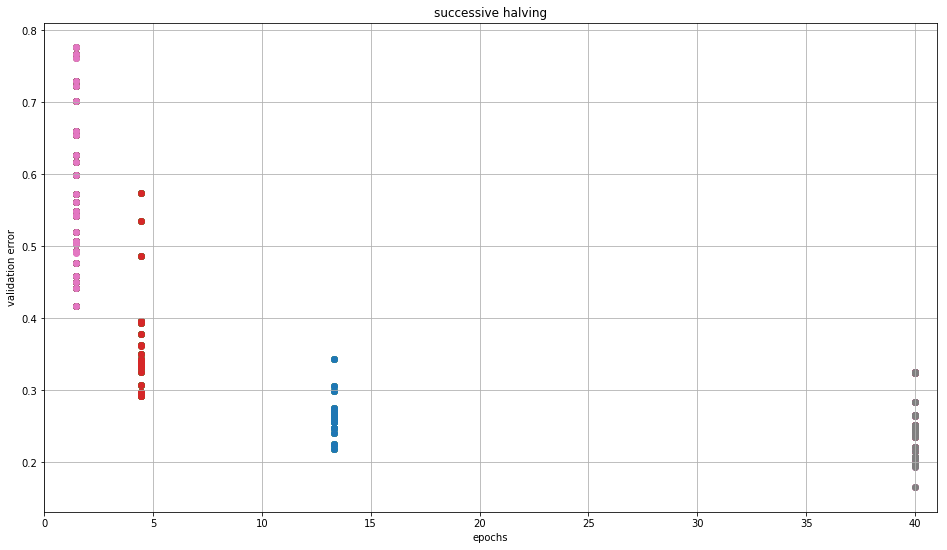

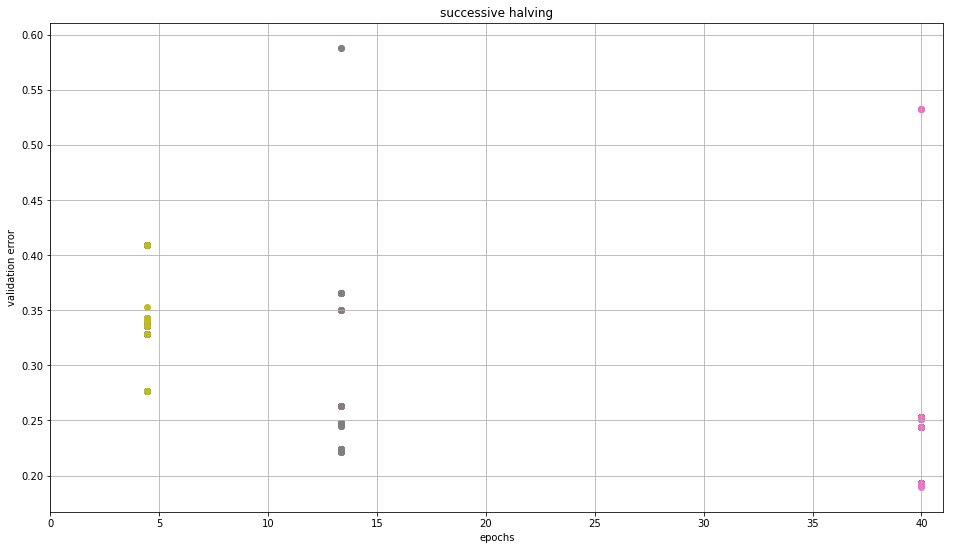

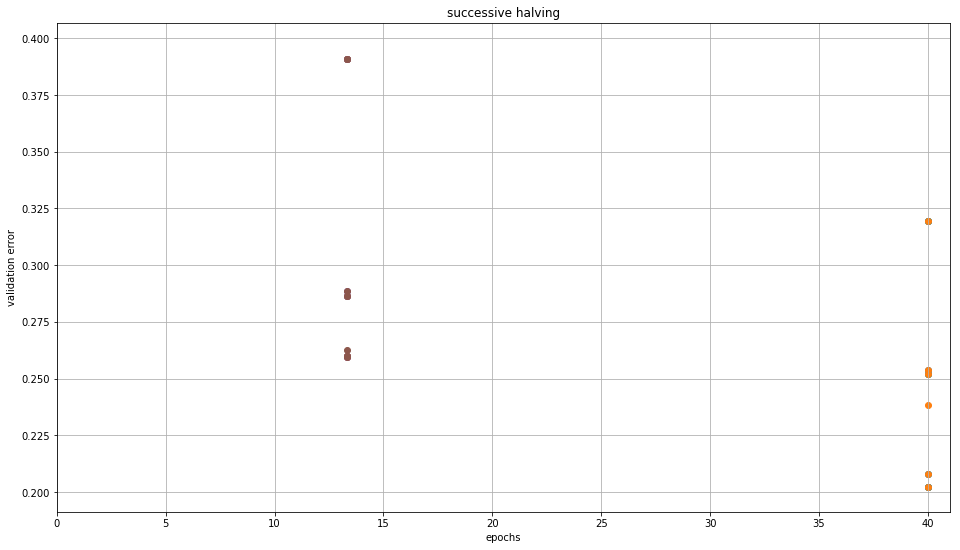

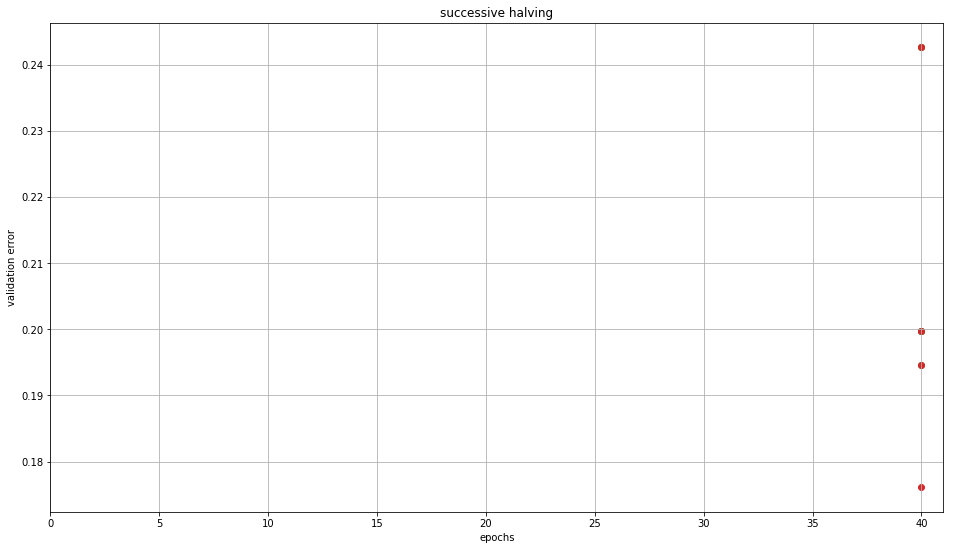

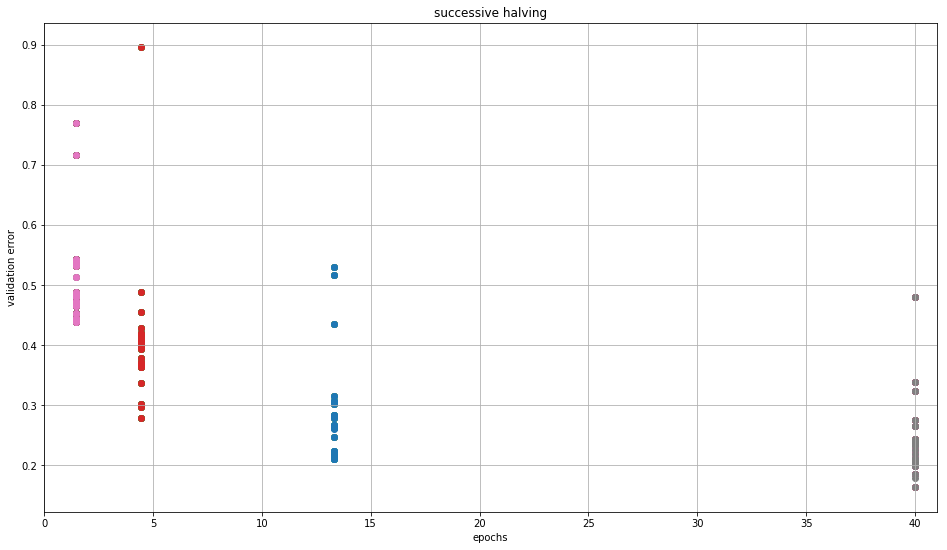

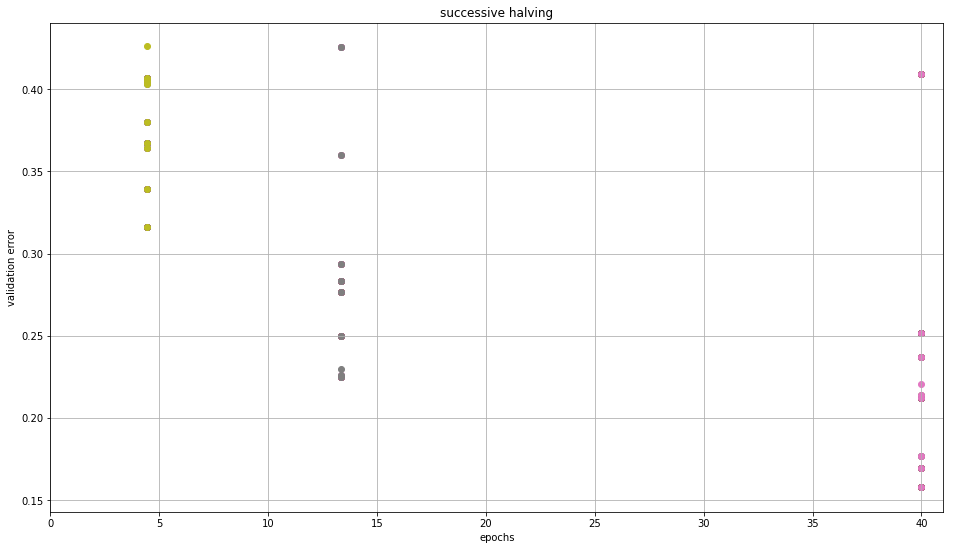

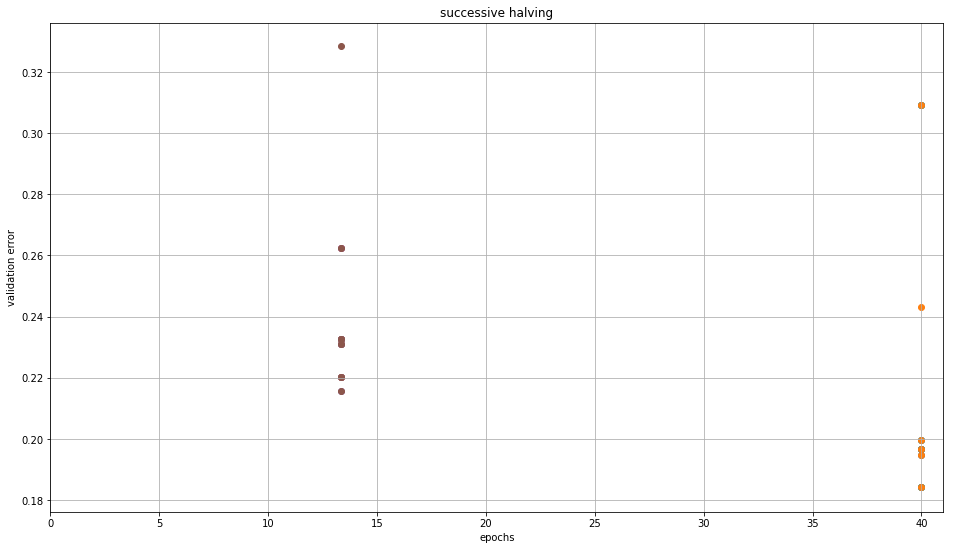

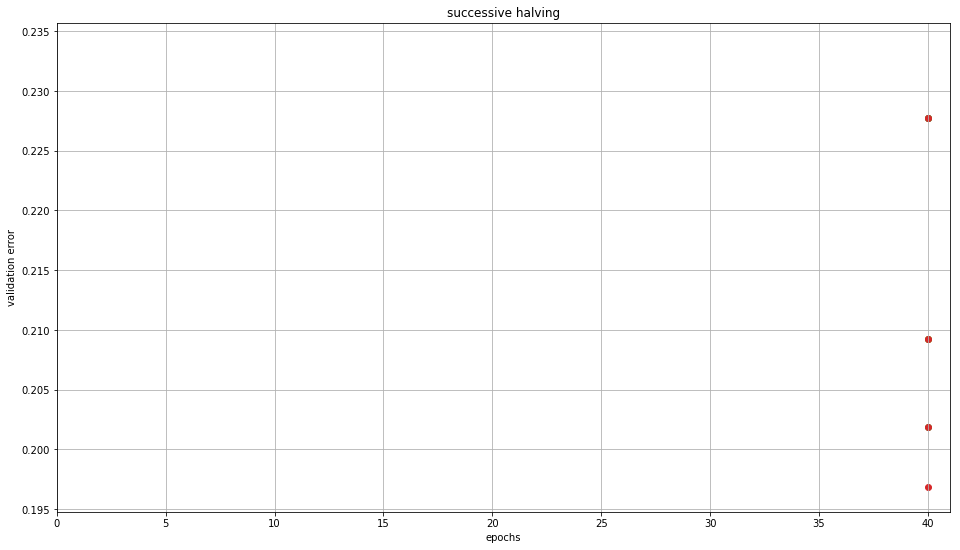

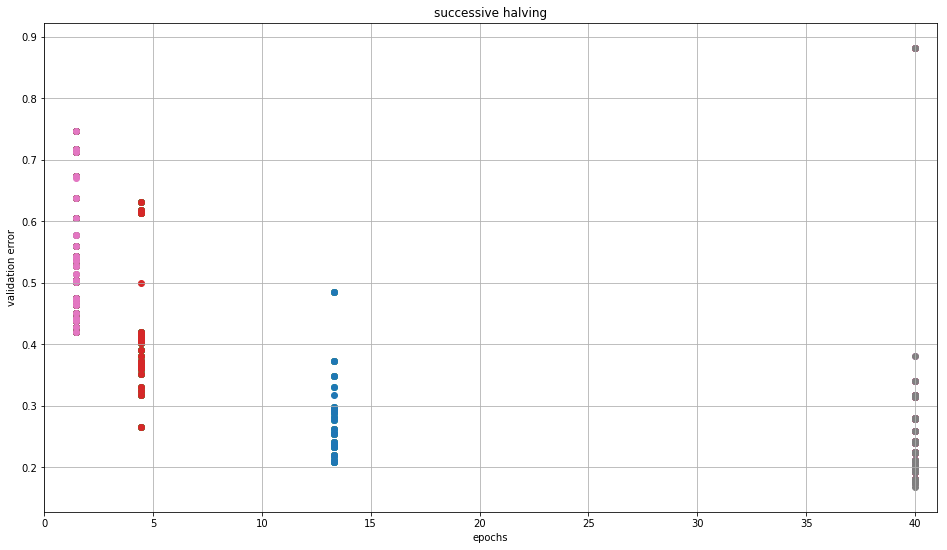

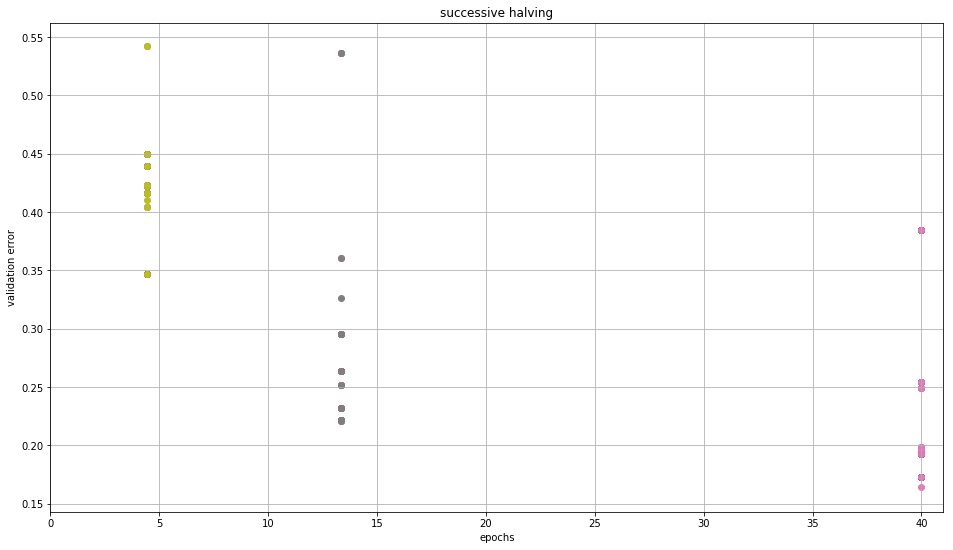

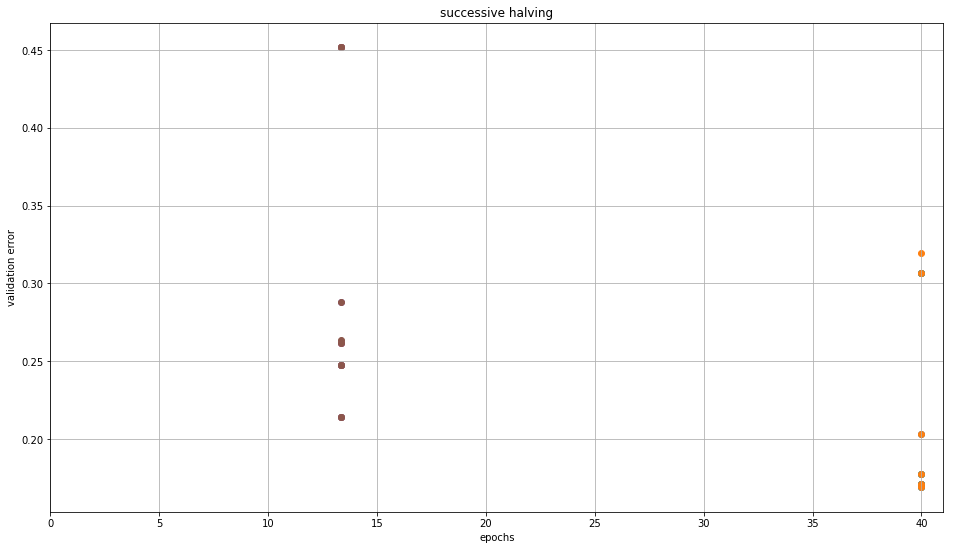

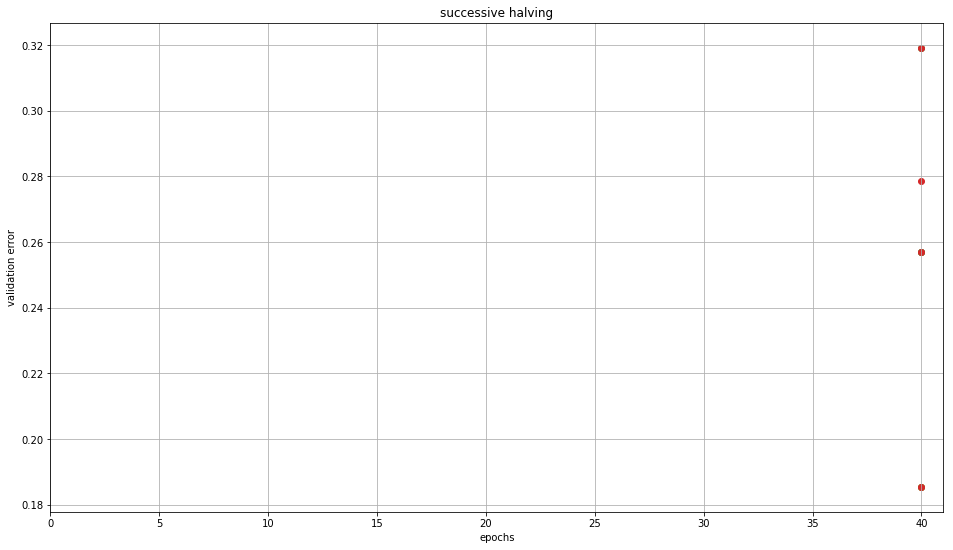

In [126]:
max_iter = 40  # maximum iterations/epochs per configuration
eta = 3 # defines downsampling rate (default=3)
s_max = int(np.log(max_iter)/np.log(eta))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of successive halving (n,r)

# for visualization purposes only
runtime_trajectory = []
loss_over_time = []
sampled_from_model = []
current_time = 0

# dictionaries for bookkeeping: the keys will be the corresponding budgets
configs = dict()
losses = dict()
kde_models = dict()

# Run K brackets of successive halving with different n and r
for k in range(12):

    s = int(np.arange(s_max + 1)[::-1][k % (s_max+1)])
    n = int(np.ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s) # initial number of iterations to run configurations for

    for i in range(s+1):

        # Run each of the n_i configs for r_i iterations and keep best n_i/eta
        n_i = n*eta**(-i)
        r_i = r*eta**(i)
        val_losses = []
        T = []
        for j in range(n):
            x_new, from_model = sample()
            y_new = objective_function(x_new, epoch=r_i)        
            
            c_new = runtime(x_new, epoch=r_i)      
            
            current_time += c_new
            sampled_from_model.append(from_model)
            runtime_trajectory.append(current_time)
            loss_over_time.append(y_new)
            
            val_losses.append(y_new)
            T.append(x_new)
            update(r_i, x_new, y_new)
            plt.scatter(np.ones(len(val_losses)) * r_i, val_losses)
        T = [ T[i] for i in np.argsort(val_losses)[0:int( n_i/eta )] ]
        
    plt.xlabel("epochs")
    plt.ylabel("validation error")
    plt.grid(True)
    plt.title("successive halving")
    plt.xlim(0, 41)
    plt.show()

Text(0.5, 0, 'runtime (seconds)')

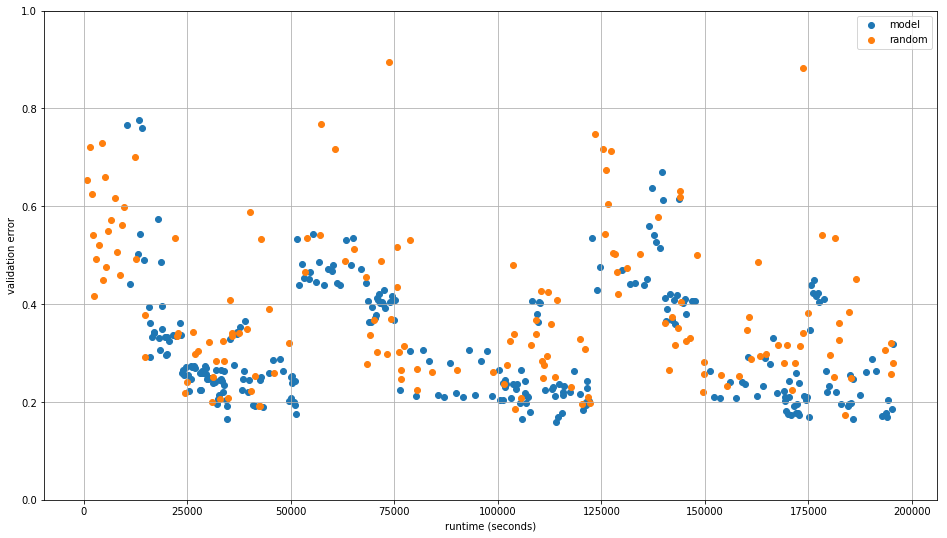

In [127]:
plt.scatter(np.array(runtime_trajectory)[sampled_from_model], np.array(loss_over_time)[sampled_from_model], label="model")
not_sampled_from_model = [not i for i in sampled_from_model]

plt.scatter(np.array(runtime_trajectory)[not_sampled_from_model], np.array(loss_over_time)[not_sampled_from_model], label="random")

plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.ylabel("validation error")
plt.xlabel("runtime (seconds)")